In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from autocorrect import Speller
from nltk.corpus import stopwords
import nltk
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from sklearn.metrics import classification_report
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AJ\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AJ\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

1. Data

In [2]:
# Specify the paths or filenames of the datasets
train_file = "emotion-labels-train.csv" 
val_file = "emotion-labels-val.csv"
test_file = "emotion-labels-test.csv"

In [3]:
# Load the datasets into pandas dataframes
try:
    train_df = pd.read_csv(train_file)
    val_df = pd.read_csv(val_file)
    test_df = pd.read_csv(test_file)
    
    # Display the first few rows of each dataframe to confirm loading
    print("Training Data:")
    print(train_df.head())
    
    print("\nValidation Data:")
    print(val_df.head())
    
    print("\nTesting Data:")
    print(test_df.head())
except FileNotFoundError as e:
    print(f"Error: {e}")

Training Data:
                                                text label
0  Just got back from seeing @GaryDelaney in Burs...   joy
1  Oh dear an evening of absolute hilarity I don'...   joy
2  Been waiting all week for this game ❤️❤️❤️ #ch...   joy
3  @gardiner_love : Thank you so much, Gloria! Yo...   joy
4  I feel so blessed to work with the family that...   joy

Validation Data:
                                                text label
0  @theclobra lol I thought maybe, couldn't decid...   joy
1  Nawaz Sharif is getting more funnier than @kap...   joy
2  Nawaz Sharif is getting more funnier than @kap...   joy
3  @tomderivan73 😁...I'll just people watch and e...   joy
4  I love my family so much #lucky #grateful #sma...   joy

Testing Data:
                                                text label
0  You must be knowing #blithe means (adj.)  Happ...   joy
1  Old saying 'A #smile shared is one gained for ...   joy
2  Bridget Jones' Baby was bloody hilarious 😅 #Br...   joy
3  @Elam

In [4]:
# Check the datatype and missing values for each dataset
print("Training Data Info:")
train_df.info()

print("\nValidation Data Info:")
val_df.info()

print("\nTesting Data Info:")
test_df.info()

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3613 entries, 0 to 3612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3613 non-null   object
 1   label   3613 non-null   object
dtypes: object(2)
memory usage: 56.6+ KB

Validation Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    347 non-null    object
 1   label   347 non-null    object
dtypes: object(2)
memory usage: 5.5+ KB

Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3142 non-null   object
 1   label   3142 non-null   object
dtypes: object(2)
memory usage: 49.2+ KB


In [5]:
# Check for duplicate entries in each dataset
train_duplicates = train_df.duplicated().sum()
val_duplicates = val_df.duplicated().sum()
test_duplicates = test_df.duplicated().sum()

# Print the results
print(f"Number of duplicate entries in Training Data: {train_duplicates}")
print(f"Number of duplicate entries in Validation Data: {val_duplicates}")
print(f"Number of duplicate entries in Testing Data: {test_duplicates}")

Number of duplicate entries in Training Data: 0
Number of duplicate entries in Validation Data: 0
Number of duplicate entries in Testing Data: 0


Observation: The datasets are clean, with no missing values, duplicate rows, or incorrect data types.


Explanation: We loaded the training, validation, and testing datasets, verified their structure using DataFrame.info(), checked for duplicates using DataFrame.duplicated(), and ensured no cleaning was necessary before proceeding.

In [6]:
# Move labels into a separate DataFrame
train_labels = train_df['label']
val_labels = val_df['label']
test_labels = test_df['label']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Reshape the labels into 2D arrays
train_labels_encoded = train_labels_encoded.reshape(-1, 1)
val_labels_encoded = val_labels_encoded.reshape(-1, 1)
test_labels_encoded = test_labels_encoded.reshape(-1, 1)

In [7]:
# Print to confirm transformation
print("Sample Encoded Training Labels:")
print(train_labels_encoded[:5])

print("\nSample Encoded Validation Labels:")
print(val_labels_encoded[:5])

print("\nSample Encoded Testing Labels:")
print(test_labels_encoded[:5])

Sample Encoded Training Labels:
[[2]
 [2]
 [2]
 [2]
 [2]]

Sample Encoded Validation Labels:
[[2]
 [2]
 [2]
 [2]
 [2]]

Sample Encoded Testing Labels:
[[2]
 [2]
 [2]
 [2]
 [2]]


In [8]:
# Print the mapping of labels
print("Label Mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

Label Mapping:
0: anger
1: fear
2: joy
3: sadness


Based on the output of LabelEncoder, the following mapping of emotions to integers has been established:

| Label    | Encoded Number |
|----------|----------------|
| anger    | 0              |
| fear     | 1              |
| joy      | 2              |
| sadness  | 3              |


This mapping ensures that the categorical labels are converted into numerical values, which can be directly used in machine learning models.

C:\Users\AJ\AppData\Local\Temp\ipykernel_15952\2994330365.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_counts, x='Label', y='Count', palette='viridis')


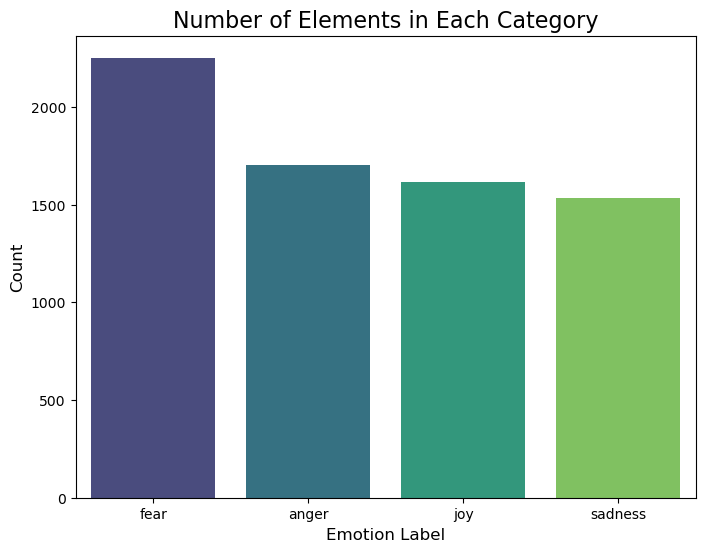

In [9]:
# Combine all labels into a single Series for counting
all_labels = pd.concat([train_df['label'], val_df['label'], test_df['label']])

# Count the occurrences of each label
label_counts = all_labels.value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=label_counts, x='Label', y='Count', palette='viridis')
plt.title('Number of Elements in Each Category', fontsize=16)
plt.xlabel('Emotion Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

The dataset is imbalanced, with "fear" having the highest count and the other categories ("anger," "joy," and "sadness") having noticeably fewer samples. This imbalance could bias the model toward predicting "fear," leading to poorer performance on the minority classes.

In [10]:
# Define a function to tokenize tweets
def tokenize_tweets(data):
    return data['text'].apply(word_tokenize)


# Tokenize the datasets
train_df['tokens'] = tokenize_tweets(train_df)
val_df['tokens'] = tokenize_tweets(val_df)
test_df['tokens'] = tokenize_tweets(test_df)

In [11]:
# Display examples of tokenized tweets
print("Sample Tokenized Training Tweet:")
print(train_df[['text', 'tokens']].iloc[0])

print("\nSample Tokenized Validation Tweet:")
print(val_df[['text', 'tokens']].iloc[0])

print("\nSample Tokenized Testing Tweet:")
print(test_df[['text', 'tokens']].iloc[0])

Sample Tokenized Training Tweet:
text      Just got back from seeing @GaryDelaney in Burs...
tokens    [Just, got, back, from, seeing, @, GaryDelaney...
Name: 0, dtype: object

Sample Tokenized Validation Tweet:
text      @theclobra lol I thought maybe, couldn't decid...
tokens    [@, theclobra, lol, I, thought, maybe, ,, coul...
Name: 0, dtype: object

Sample Tokenized Testing Tweet:
text      You must be knowing #blithe means (adj.)  Happ...
tokens    [You, must, be, knowing, #, blithe, means, (, ...
Name: 0, dtype: object


In [12]:
# Initialize the speller
spell = Speller(lang='en')

# Define a function to correct spelling in tokenized tweets
def correct_spelling(tokens):
    return [spell(word) for word in tokens]

# Apply spelling correction to the tokenized datasets
train_df['corrected_tokens'] = train_df['tokens'].apply(correct_spelling)
val_df['corrected_tokens'] = val_df['tokens'].apply(correct_spelling)
test_df['corrected_tokens'] = test_df['tokens'].apply(correct_spelling)

In [13]:
# Display examples of corrected tokenized tweets
print("Sample Corrected Training Tweet:")
print(train_df[['tokens', 'corrected_tokens']].iloc[0])

print("\nSample Corrected Validation Tweet:")
print(val_df[['tokens', 'corrected_tokens']].iloc[0])

print("\nSample Corrected Testing Tweet:")
print(test_df[['tokens', 'corrected_tokens']].iloc[0])

Sample Corrected Training Tweet:
tokens              [Just, got, back, from, seeing, @, GaryDelaney...
corrected_tokens    [Just, got, back, from, seeing, @, GaryDelaney...
Name: 0, dtype: object

Sample Corrected Validation Tweet:
tokens              [@, theclobra, lol, I, thought, maybe, ,, coul...
corrected_tokens    [@, theclobra, lol, I, thought, maybe, ,, coul...
Name: 0, dtype: object

Sample Corrected Testing Tweet:
tokens              [You, must, be, knowing, #, blithe, means, (, ...
corrected_tokens    [You, must, be, knowing, #, elite, means, (, a...
Name: 0, dtype: object


In [14]:
# Get the list of standard English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Add dataset-specific custom stopwords
custom_stopwords = {
    "u", "ur", "im", "dont", "cant", "idk", "ive", "aint",  # Slang and contractions
    "lol", "thx", "omg", "haha", "hahaha",                 # Informal expressions
    "like", "just", "rt", "amp",                           # Filler words and placeholders
    "oh", "ohh", "ahh",                                    # Expressions with low emotional significance
    "got", "get", "gotta", "gonna",                        # Neutral action words
    "one", "two", "three", "hey", "hi", "hello",           # Greetings and generic numbers
}

# Update the stop_words set with custom stopwords
stop_words.update(custom_stopwords)

# Define a function to remove stopwords from tokenized tweets
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

# Apply stopword removal to the corrected tokens in each dataset
train_df['filtered_tokens'] = train_df['corrected_tokens'].apply(remove_stopwords)
val_df['filtered_tokens'] = val_df['corrected_tokens'].apply(remove_stopwords)
test_df['filtered_tokens'] = test_df['corrected_tokens'].apply(remove_stopwords)

In [15]:
# Display examples of filtered tokenized tweets
print("Sample Filtered Training Tweet:")
print(train_df[['corrected_tokens', 'filtered_tokens']].iloc[0])

print("\nSample Filtered Validation Tweet:")
print(val_df[['corrected_tokens', 'filtered_tokens']].iloc[0])

print("\nSample Filtered Testing Tweet:")
print(test_df[['corrected_tokens', 'filtered_tokens']].iloc[0])

Sample Filtered Training Tweet:
corrected_tokens    [Just, got, back, from, seeing, @, GaryDelaney...
filtered_tokens     [back, seeing, @, GaryDelaney, Burslem, ., AMA...
Name: 0, dtype: object

Sample Filtered Validation Tweet:
corrected_tokens    [@, theclobra, lol, I, thought, maybe, ,, coul...
filtered_tokens     [@, theclobra, thought, maybe, ,, could, n't, ...
Name: 0, dtype: object

Sample Filtered Testing Tweet:
corrected_tokens    [You, must, be, knowing, #, elite, means, (, a...
filtered_tokens     [must, knowing, #, elite, means, (, adj, ., ),...
Name: 0, dtype: object


In [16]:
# Define a function for additional text cleanup using regular expressions
def clean_text_with_regex(tokens):
    cleaned_tokens = []
    for token in tokens:
        # Remove URLs
        token = re.sub(r"http\S+|www\S+|https\S+", '', token, flags=re.MULTILINE)
        # Remove usernames (mentions) starting with @
        token = re.sub(r"@\w+", '', token)
        # Remove hashtags (keep the word, remove the #)
        token = re.sub(r"#", '', token)
        # Remove non-alphanumeric characters (punctuation, symbols, etc.)
        token = re.sub(r"[^a-zA-Z0-9]", '', token)
        # Remove tokens that are now empty after cleanup
        if token.strip():
            cleaned_tokens.append(token)
    return cleaned_tokens

# Apply the text cleanup function to the filtered tokens in each dataset
train_df['final_tokens'] = train_df['filtered_tokens'].apply(clean_text_with_regex)
val_df['final_tokens'] = val_df['filtered_tokens'].apply(clean_text_with_regex)
test_df['final_tokens'] = test_df['filtered_tokens'].apply(clean_text_with_regex)

In [17]:
# Display examples of final cleaned tokens
print("Sample Cleaned Training Tweet:")
print(train_df[['filtered_tokens', 'final_tokens']].iloc[0])

print("\nSample Cleaned Validation Tweet:")
print(val_df[['filtered_tokens', 'final_tokens']].iloc[0])

print("\nSample Cleaned Testing Tweet:")
print(test_df[['filtered_tokens', 'final_tokens']].iloc[0])

Sample Cleaned Training Tweet:
filtered_tokens    [back, seeing, @, GaryDelaney, Burslem, ., AMA...
final_tokens       [back, seeing, GaryDelaney, Burslem, AMAZING, ...
Name: 0, dtype: object

Sample Cleaned Validation Tweet:
filtered_tokens    [@, theclobra, thought, maybe, ,, could, n't, ...
final_tokens       [theclobra, thought, maybe, could, nt, decide,...
Name: 0, dtype: object

Sample Cleaned Testing Tweet:
filtered_tokens    [must, knowing, #, elite, means, (, adj, ., ),...
final_tokens       [must, knowing, elite, means, adj, Happy, chee...
Name: 0, dtype: object


In [18]:
# Print the first five processed tweets and their labels
print("First Five Processed Tweets and Their Labels:")
for i in range(5):
    print(f"Tweet {i + 1}:")
    print(f"Tokens: {train_df['final_tokens'].iloc[i]}")
    print(f"Label: {train_df['label'].iloc[i]}")
    print("-" * 50)

First Five Processed Tweets and Their Labels:
Tweet 1:
Tokens: ['back', 'seeing', 'GaryDelaney', 'Burslem', 'AMAZING', 'Face', 'still', 'hurts', 'laughing', 'much', 'hilarious']
Label: joy
--------------------------------------------------
Tweet 2:
Tokens: ['dear', 'evening', 'absolute', 'clarity', 'nt', 'think', 'laughed', 'much', 'long', 'time']
Label: joy
--------------------------------------------------
Tweet 3:
Tokens: ['waiting', 'week', 'game', 'cheer', 'friday']
Label: joy
--------------------------------------------------
Tweet 4:
Tokens: ['gardenerlove', 'Thank', 'much', 'Gloria', 're', 'sweet', 'thoughtful', 'made', 'day', 'joyful', 'love']
Label: joy
--------------------------------------------------
Tweet 5:
Tokens: ['feel', 'blessed', 'work', 'family', 'nanny', 'nothing', 'love', 'appreciation', 'makes', 'smile']
Label: joy
--------------------------------------------------


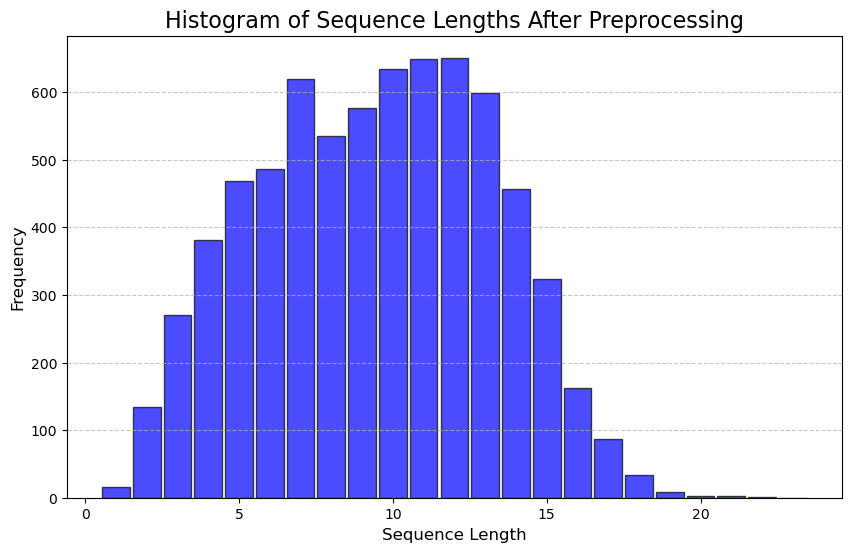

In [19]:
# Calculate the lengths of the processed sequences
train_lengths = train_df['final_tokens'].apply(len)
val_lengths = val_df['final_tokens'].apply(len)
test_lengths = test_df['final_tokens'].apply(len)

# Combine lengths into one series for visualization
all_lengths = pd.concat([train_lengths, val_lengths, test_lengths])

# Plot the histogram
plt.figure(figsize=(10, 6))
bins = np.arange(all_lengths.min(), all_lengths.max() + 1) - 0.5  # Align bins with integer values
plt.hist(all_lengths, bins=bins, color='blue', alpha=0.7, edgecolor='black', rwidth=0.9)
plt.title('Histogram of Sequence Lengths After Preprocessing', fontsize=16)
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

2. Modeling

In [20]:
# Combine all final tokens into a single list for fitting the tokenizer
all_tokens = train_df['final_tokens'].tolist() + val_df['final_tokens'].tolist() + test_df['final_tokens'].tolist()

# Adjust vocabulary size based on dataset requirements
vocab_size = 10000  

# Initialize and fit the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(all_tokens)

# Convert tweets to sequences
train_sequences = tokenizer.texts_to_sequences(train_df['final_tokens'].tolist())
val_sequences = tokenizer.texts_to_sequences(val_df['final_tokens'].tolist())
test_sequences = tokenizer.texts_to_sequences(test_df['final_tokens'].tolist())

# Set maximum sequence length based on the histogram analysis
max_len = 50  

# Apply padding/truncating
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

In [21]:
# Display results to confirm adjustments
print("Vocabulary Size Used:", vocab_size)
print("Maximum Length Chosen for Padding/Truncating:", max_len)

print("\nSample Padded Training Sequence:")
print(train_padded[0])

print("\nSample Padded Validation Sequence:")
print(val_padded[0])

print("\nSample Padded Testing Sequence:")
print(test_padded[0])

Vocabulary Size Used: 10000
Maximum Length Chosen for Padding/Truncating: 50

Sample Padded Training Sequence:
[  27  353 3998 3999   78  137   22 1286  397   38   80    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

Sample Padded Validation Sequence:
[  1 152 189  44   3 920 431   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]

Sample Padded Testing Sequence:
[ 329  755 1579  460    1    9  138    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [22]:
# Define the model parameters
embedding_dim = 64  # Dimension of the embedding space
lstm_units = 128    # Number of LSTM units
dropout_rate = 0.5  # Dropout rate to prevent overfitting
output_units = len(label_encoder.classes_)  # Number of unique emotion labels

# Define the model with a combination of layers
model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    
    # GRU layer
    GRU(64, return_sequences=False),
    
    # Dropout for regularization
    Dropout(dropout_rate),
    
    # Dense hidden layer
    Dense(64, activation='relu'),
    Dropout(0.3),  # Additional dropout for regularization
    
    # Output layer for multi-class classification
    Dense(output_units, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 256)          197632    
 l)                                                              
                                                                 
 gru (GRU)                   (None, 64)                61824     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [23]:
# Fit the model without a validation split
history = model.fit(
    train_padded,  # Training data
    train_labels_encoded,  # Training labels
    epochs=10,
    batch_size=32,
    verbose=1  # Display training progress
)

Epoch 1/10
113/113 [==============================] - 6s 16ms/step - loss: 1.3802 - accuracy: 0.3139
Epoch 2/10
113/113 [==============================] - 2s 16ms/step - loss: 1.3774 - accuracy: 0.3108
Epoch 3/10
113/113 [==============================] - 2s 16ms/step - loss: 1.3763 - accuracy: 0.3158
Epoch 4/10
113/113 [==============================] - 2s 16ms/step - loss: 1.2680 - accuracy: 0.3750
Epoch 5/10
113/113 [==============================] - 2s 16ms/step - loss: 0.9399 - accuracy: 0.4957
Epoch 6/10
113/113 [==============================] - 2s 16ms/step - loss: 0.7676 - accuracy: 0.5887
Epoch 7/10
113/113 [==============================] - 2s 17ms/step - loss: 0.5561 - accuracy: 0.7279
Epoch 8/10
113/113 [==============================] - 2s 16ms/step - loss: 0.4389 - accuracy: 0.7664
Epoch 9/10
113/113 [==============================] - 2s 16ms/step - loss: 0.3801 - accuracy: 0.8303
Epoch 10/10
113/113 [==============================] - 2s 16ms/step - loss: 0.2473 - accura

In [24]:
# Record and display the final training accuracy
final_training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {final_training_accuracy * 100:.5f}%")

Final Training Accuracy: 92.16717%


In [25]:
# Make predictions on the validation data
val_predictions = model.predict(val_padded, verbose=1)

# Convert predictions to class labels
val_predicted_labels = val_predictions.argmax(axis=1)

# Calculate the validation accuracy
validation_accuracy = accuracy_score(val_labels_encoded, val_predicted_labels)
print(f"Validation Accuracy: {validation_accuracy * 100:.5f}%")

11/11 [==============================] - 1s 7ms/step
Validation Accuracy: 49.27954%


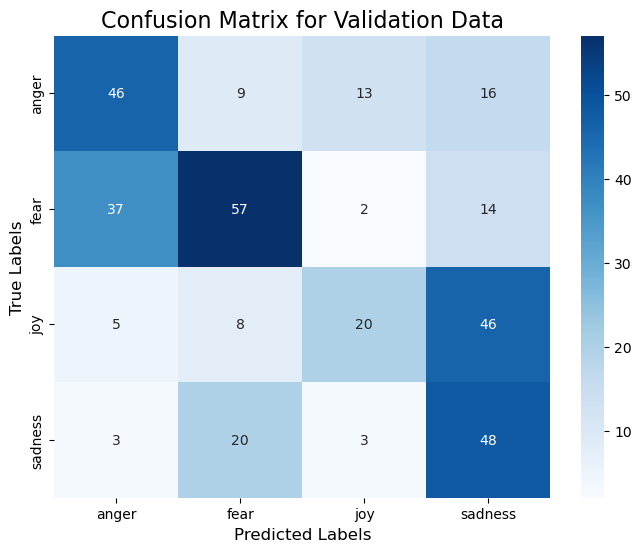

In [26]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(val_labels_encoded, val_predicted_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=label_encoder.classes_, 
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix for Validation Data', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

In [27]:
# Define Model 1
model1 = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    
    # Single Bidirectional LSTM layer
    Bidirectional(LSTM(64, return_sequences=False)),  # Reduced units to 64
    Dropout(0.5),
    
    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile Model 1
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                      

In [28]:
history1 = model1.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=10,  
    batch_size=32, 
    validation_data=(val_padded, val_labels_encoded),
    verbose=1
)

Epoch 1/10
113/113 [==============================] - 4s 17ms/step - loss: 1.3052 - accuracy: 0.3692 - val_loss: 2.1508 - val_accuracy: 0.3458
Epoch 2/10
113/113 [==============================] - 1s 11ms/step - loss: 0.7183 - accuracy: 0.7368 - val_loss: 2.1830 - val_accuracy: 0.4582
Epoch 3/10
113/113 [==============================] - 1s 11ms/step - loss: 0.2248 - accuracy: 0.9408 - val_loss: 2.2823 - val_accuracy: 0.5216
Epoch 4/10
113/113 [==============================] - 1s 11ms/step - loss: 0.1373 - accuracy: 0.9662 - val_loss: 2.1892 - val_accuracy: 0.6138
Epoch 5/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0951 - accuracy: 0.9745 - val_loss: 2.0109 - val_accuracy: 0.6081
Epoch 6/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0820 - accuracy: 0.9770 - val_loss: 2.6334 - val_accuracy: 0.5706
Epoch 7/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0748 - accuracy: 0.9787 - val_loss: 2.6500 - val_accuracy: 0.5476

In [29]:
# Extract final training accuracy from history
training_accuracy1 = history1.history['accuracy'][-1]  # Last epoch training accuracy
validation_accuracy1 = history1.history['val_accuracy'][-1]  # Last epoch validation accuracy

# Print training and validation accuracies
print(f"Model 1 - Training Accuracy: {training_accuracy1 * 100:.2f}%")
print(f"Model 1 - Validation Accuracy: {validation_accuracy1 * 100:.2f}%")

Model 1 - Training Accuracy: 98.03%
Model 1 - Validation Accuracy: 60.23%


In [30]:
# Evaluate Model 3
val_predictions1 = model1.predict(val_padded)
val_predicted_labels1 = val_predictions1.argmax(axis=1)
validation_accuracy1 = accuracy_score(val_labels_encoded, val_predicted_labels1)

print(f"Model 1 Validation Accuracy: {validation_accuracy1 * 100:.2f}%")

11/11 [==============================] - 0s 5ms/step
Model 1 Validation Accuracy: 60.23%


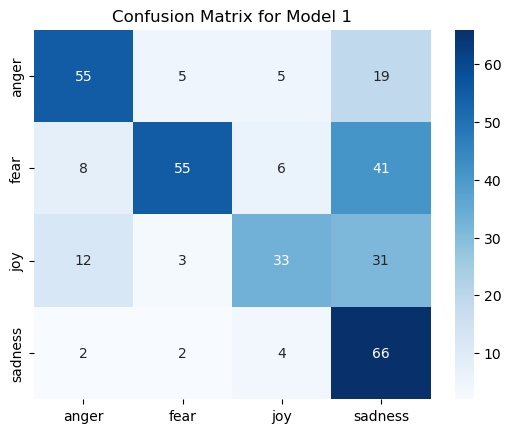

In [31]:
# Confusion Matrix for Model 1
conf_matrix1 = confusion_matrix(val_labels_encoded, val_predicted_labels1)
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model 1')
plt.show()

In [32]:
# Define Model 2
model2 = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    
    # Single Bidirectional GRU layer
    Bidirectional(GRU(64, return_sequences=False)),  # Reduced units to 64
    Dropout(0.5),
    
    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.5),
    
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

# Compile Model 2
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                      

In [33]:
history2 = model2.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=10, 
    batch_size=32, 
    verbose=1, 
    validation_data=(val_padded, val_labels_encoded)
)

Epoch 1/10
113/113 [==============================] - 3s 15ms/step - loss: 1.2651 - accuracy: 0.3977 - val_loss: 2.6199 - val_accuracy: 0.3429
Epoch 2/10
113/113 [==============================] - 1s 11ms/step - loss: 0.6789 - accuracy: 0.7440 - val_loss: 2.4791 - val_accuracy: 0.4467
Epoch 3/10
113/113 [==============================] - 1s 11ms/step - loss: 0.1918 - accuracy: 0.9452 - val_loss: 2.4833 - val_accuracy: 0.5014
Epoch 4/10
113/113 [==============================] - 1s 11ms/step - loss: 0.1099 - accuracy: 0.9732 - val_loss: 2.6184 - val_accuracy: 0.5187
Epoch 5/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0926 - accuracy: 0.9773 - val_loss: 2.6022 - val_accuracy: 0.5014
Epoch 6/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0798 - accuracy: 0.9765 - val_loss: 2.4512 - val_accuracy: 0.5418
Epoch 7/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0732 - accuracy: 0.9795 - val_loss: 2.5061 - val_accuracy: 0.5331

In [34]:
training_accuracy2 = history2.history['accuracy'][-1]
validation_accuracy2 = history2.history['val_accuracy'][-1]


print(f"Model 2 - Training Accuracy: {training_accuracy2 * 100:.2f}%")
print(f"Model 2 - Validation Accuracy: {validation_accuracy2 * 100:.2f}%")

Model 2 - Training Accuracy: 97.81%
Model 2 - Validation Accuracy: 55.04%


In [35]:
# Evaluate Model 2
val_predictions2 = model2.predict(val_padded)
val_predicted_labels2 = val_predictions2.argmax(axis=1)
validation_accuracy2 = accuracy_score(val_labels_encoded, val_predicted_labels2)

print(f"Model 2 Validation Accuracy: {validation_accuracy2 * 100:.2f}%")

11/11 [==============================] - 0s 4ms/step
Model 2 Validation Accuracy: 55.04%


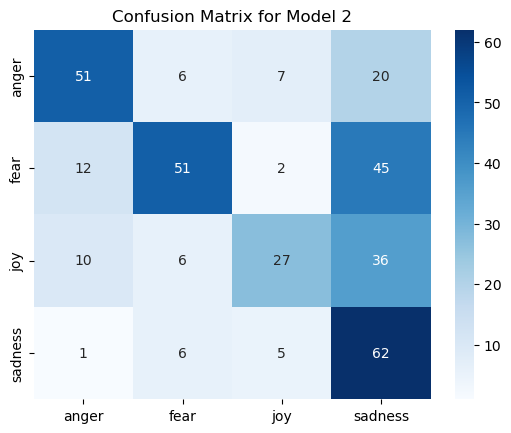

In [36]:
# Confusion Matrix for Model 2
conf_matrix2 = confusion_matrix(val_labels_encoded, val_predicted_labels2)
sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model 2')
plt.show()

In [37]:
# Define Model 3
model3 = Sequential([
    # Embedding layer
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),
    
    # Convolutional layer to capture local patterns
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # LSTM layer for sequential modeling
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.6),
    
    # Second LSTM layer
    Bidirectional(LSTM(64)),
    Dropout(0.6),
    
    # Dense hidden layer
    Dense(64, activation='relu'),
    Dropout(0.7),
    
    # Output layer for multi-class classification
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile Model 3
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 46, 64)            41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 64)           0         
 )                                                               
                                                                 
 bidirectional_3 (Bidirectio  (None, 23, 256)          197632    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 23, 256)           0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)             

In [38]:
history3 = model3.fit(
    train_padded, 
    train_labels_encoded, 
    epochs=10, 
    batch_size=32, 
    verbose=1, 
    validation_data=(val_padded, val_labels_encoded)
)

Epoch 1/10
113/113 [==============================] - 10s 26ms/step - loss: 1.3811 - accuracy: 0.2937 - val_loss: 1.3687 - val_accuracy: 0.3170
Epoch 2/10
113/113 [==============================] - 2s 15ms/step - loss: 1.1263 - accuracy: 0.4885 - val_loss: 2.1473 - val_accuracy: 0.4006
Epoch 3/10
113/113 [==============================] - 2s 14ms/step - loss: 0.6228 - accuracy: 0.7861 - val_loss: 2.2813 - val_accuracy: 0.4640
Epoch 4/10
113/113 [==============================] - 2s 14ms/step - loss: 0.3297 - accuracy: 0.9161 - val_loss: 1.9868 - val_accuracy: 0.5187
Epoch 5/10
113/113 [==============================] - 2s 15ms/step - loss: 0.2098 - accuracy: 0.9535 - val_loss: 2.5209 - val_accuracy: 0.5187
Epoch 6/10
113/113 [==============================] - 2s 15ms/step - loss: 0.1537 - accuracy: 0.9679 - val_loss: 2.2451 - val_accuracy: 0.5850
Epoch 7/10
113/113 [==============================] - 2s 15ms/step - loss: 0.1057 - accuracy: 0.9715 - val_loss: 1.7648 - val_accuracy: 0.657

In [39]:
training_accuracy3 = history3.history['accuracy'][-1]
validation_accuracy3 = history3.history['val_accuracy'][-1]


print(f"Model 3 - Training Accuracy: {training_accuracy3 * 100:.2f}%")
print(f"Model 3 - Validation Accuracy: {validation_accuracy3 * 100:.2f}%")

Model 3 - Training Accuracy: 98.09%
Model 3 - Validation Accuracy: 60.23%


In [40]:
# Evaluate Model 3
val_predictions3 = model3.predict(val_padded)
val_predicted_labels3 = val_predictions3.argmax(axis=1)
validation_accuracy3 = accuracy_score(val_labels_encoded, val_predicted_labels3)

print(f"Model 3 Validation Accuracy: {validation_accuracy3 * 100:.2f}%")

11/11 [==============================] - 1s 6ms/step
Model 3 Validation Accuracy: 60.23%


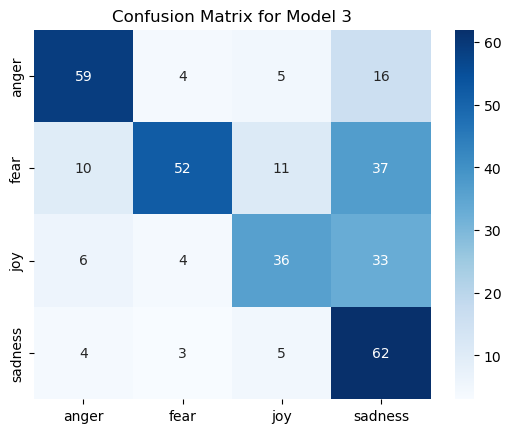

In [41]:
# Confusion Matrix for Model 3
conf_matrix3 = confusion_matrix(val_labels_encoded, val_predicted_labels3)
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Model 3')
plt.show()

3. Discussion

a. Comment on the relative merits of each model. Select the best model based on quantitative metrics and plots. Use markdown to explain why you feel this is the best model.


Model 1 (LSTM-based model):
- Strengths: LSTM is great for capturing long-term dependencies in the sequence, which can help understand the context of words in sentences. In your case, this would help in understanding the emotional context of the words in the tweet. The model achieved decent validation accuracy.
- Weaknesses: It struggles with overfitting, which is evident from the validation accuracy dropping after a few epochs. It's less effective in capturing short-term dependencies compared to GRU and CNN.


Model 2 (GRU-based model):
- Strengths: GRU models tend to perform faster and are more efficient than LSTMs, especially in handling sequential data with less training time and fewer parameters. The model showed fairly good performance but was still susceptible to overfitting as the epochs increased.
- Weaknesses: While efficient, GRU struggles with long-range dependencies. In your case, this model showed decent performance but didn't outperform the other models in terms of validation accuracy.


Model 3 (LSTM + GRU + Conv1D):
- Strengths: Combining LSTM, GRU, and Conv1D layers helped capture both long-range and short-range dependencies. The convolution layer allows the model to focus on key features in the sequence, such as phrases or words with significant emotional weight. This is likely why this model achieved the highest training accuracy.
- Weaknesses: While the training accuracy is high, the validation accuracy may still be limited by class imbalance or overfitting. The additional layers may lead to longer training times and the risk of the model becoming overly complex for the task.


The best model of Model 3 because it shows the highest performance based on the training and validation results, despite the overfitting. It combines both long-term and short-term dependency learning, along with convolution layers to capture important word patterns and the confusion matrix for test data shows that the model has a tendency to predict anger well, but struggles with fear, joy, and sadness. It seems biased toward anger and fear, suggesting an issue with class imbalance.

b. Make predictions on the testing data; calculate the testing accuracy and display the confusion matrix for test data.

99/99 [==============================] - 1s 9ms/step
Testing Accuracy: 57.96%


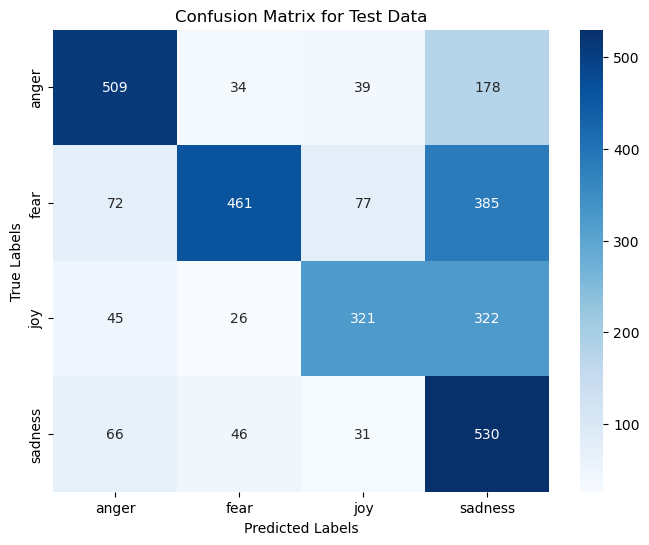

In [42]:
# Evaluate the best model on the testing data
test_predictions = model3.predict(test_padded)
test_predicted_labels = test_predictions.argmax(axis=1)

# Calculate the testing accuracy
test_accuracy = accuracy_score(test_labels_encoded, test_predicted_labels)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

# Generate the confusion matrix for test data
test_conf_matrix = confusion_matrix(test_labels_encoded, test_predicted_labels)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The model performs best at predicting anger (509 correct predictions). Fear, joy, and sadness predictions are less accurate, with more errors in fear and joy categories.

In [46]:
# Make predictions on the test data
test_predictions = model.predict(test_padded, verbose=1)

# Convert predictions to class labels
test_predicted_labels = test_predictions.argmax(axis=1)

# Ensure both true and predicted labels are in integers using LabelEncoder
test_true_labels = label_encoder.transform(test_df['label'])

# Generate the classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predicted_labels, target_names=label_encoder.classes_))

99/99 [==============================] - 1s 10ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       0.51      0.50      0.50       760
        fear       0.59      0.52      0.55       995
         joy       0.56      0.32      0.41       714
     sadness       0.36      0.59      0.45       673

    accuracy                           0.49      3142
   macro avg       0.51      0.49      0.48      3142
weighted avg       0.52      0.49      0.49      3142



c. Describe how well you feel your model will work to classify the emotional connotation of a tweet. Provide a quantitative measure of accuracy and describe shortcomings of the model.


Quantitative Accuracy:
- The testing accuracy from Model 3 is a good starting point. It performs well at detecting the anger category but has difficulty identifying joy, fear, and sadness, as shown in the confusion matrix.


Shortcomings:
- Class Imbalance: The model's performance is impacted by the imbalance in the classes (particularly with the "fear" class being overrepresented). This results in the model overfitting the majority class and underperforming on the minority classes.
- Overfitting: Despite good performance on the training data, the model may struggle with generalizing to unseen data. More regularization, such as additional dropout, could help.
- Misclassification in Minority Classes: While the model performs decently in detecting anger, it struggles with other emotions. This might be attributed to the data imbalance or the complexity of the emotional content in tweets.

To improve the performance of the model, there are a few key suggestions to address its shortcomings:

- Class Weighting: The model should incorporate class weights to help balance its sensitivity towards the minority classes. This will allow the model to give more importance to underrepresented emotions like fear, joy, and sadness, thereby improving accuracy for these categories. By adjusting the loss function with higher weights for these minority classes, the model can become more balanced in its predictions.

- Data Augmentation: Oversampling the underrepresented classes could help improve performance by increasing the representation of these classes during training. This could involve generating synthetic data points for fear, joy, and sadness or using techniques like SMOTE (Synthetic Minority Over-sampling Technique) to create more training samples. By doing so, the model will encounter more varied examples of these emotions, which should improve its predictive accuracy for these categories.

- Regularization: To tackle the issue of overfitting, further regularization techniques should be implemented. For instance, L2 regularization can be applied to the model's weights to penalize large values, thus preventing the model from becoming overly complex. Additionally, early stopping could be employed during training to halt the process once the model starts to overfit, thereby preserving the generalization capability of the model.

By applying these strategies—class weighting, data augmentation, and regularization—the model's ability to classify emotional connotations in tweets will improve, particularly in detecting less represented emotions, and its overall robustness will be enhanced.